In [1]:
import numpy                                   as np
import pandas                                  as pd
import matplotlib.pyplot                       as plt
import math
import random
from   sklearn                                 import ensemble
from   sklearn                                 import datasets
from   sklearn.utils                           import shuffle
from   sklearn.metrics                         import mean_squared_error
from   sklearn.datasets                        import load_boston
from   sklearn.model_selection                 import cross_val_score
from   sklearn.tree                            import DecisionTreeRegressor
from   sklearn.model_selection                 import train_test_split
from   sklearn.ensemble._gradient_boosting     import predict_stages
from   sklearn.ensemble._gradient_boosting     import predict_stage
from   abc                                     import abstractmethod
from   scipy.special                           import expit
from   sklearn.utils                           import check_array
from   sklearn.tree._tree                      import DTYPE
from   sklearn.tree._tree                      import TREE_LEAF
from   scipy.special                           import logsumexp
from   sklearn.utils                           import check_random_state
from   sklearn.ensemble.gradient_boosting      import ZeroEstimator
from   _aft_loss                               import loss, negative_gradient,hessian
from   gb_aft                                  import GradientBoostingClassifier,chart_creation,generate_result
import sys
import graphviz
import xgboost
sys.setrecursionlimit(10000)

In [2]:
def getInputOutputFolder(fileFlag=None):
    f  = open("data_file.txt", "r")
    i  = 0
    for l in f.readlines():
        if fileFlag<32:
            if i==fileFlag:
                foldName = l[:-1]
        if fileFlag==32:
            if i==fileFlag:
                foldName = l
        
        i = i+1
    f.close()
    dataNameSplit = foldName.split("/")
    inputFileName  = '../../data/'+ dataNameSplit[1]+'/inputs.csv'
    outputFileName = '../../data/'+ dataNameSplit[1]+'/outputs.csv'
    foldName       = '../../'+foldName
    return inputFileName,outputFileName,foldName,dataNameSplit[1]

In [3]:
# Input the File Number
# Not Working - 17,18,19,20,21,22,23,24,25
fileFlag = 25
inputFileName,outputFileName,foldName,dataName = getInputOutputFolder(fileFlag)
print(inputFileName)
print(outputFileName)
print(foldName)
print(dataName)

../../data/systematic/inputs.csv
../../data/systematic/outputs.csv
../../data/systematic/cv/R-3.6.0-chrom/folds.csv
systematic


In [4]:
input     = pd.read_csv(inputFileName)
label     = pd.read_csv(outputFileName)
folds     = pd.read_csv(foldName)
folds_iter = folds['fold'].unique()
print(folds_iter)
input.replace([np.inf, -np.inf], np.nan,inplace=True)

[1 2 3 4 5 6]


In [5]:
colnames       = input.columns.values
colnamesSeries = input.isna().sum()
nullColnames   = list(colnamesSeries.index[colnamesSeries>0].values)
nullColnames.append('sequenceID')
colnames       = [x for x in colnames if x not in nullColnames]

In [ ]:
for i in folds_iter:
    test_fold    = i
    test_id      = folds[folds["fold"]==i]['sequenceID']
    train_id     = folds[folds["fold"]!=i]['sequenceID']
    nullId       = label[(label['min.log.lambda']==-float('inf'))&(label['max.log.lambda']==float('inf'))]['sequenceID']
    X            = input[input['sequenceID'].isin(train_id)&(~input['sequenceID'].isin(nullId))]
    X_val        = input[input['sequenceID'].isin(test_id)&(~input['sequenceID'].isin(nullId))]
    
    X            = X[colnames]
    X_val        = X_val[colnames]
    y_label      = label[label['sequenceID'].isin(train_id)&(~label['sequenceID'].isin(nullId))]
    y_label_test = label[label['sequenceID'].isin(test_id)&(~label['sequenceID'].isin(nullId))]
    
    
    y_lower      = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label['min.log.lambda'])))
    y_higher     = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label['max.log.lambda'])))
    y_lower_val  = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label_test['min.log.lambda'])))
    y_higher_val = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label_test['max.log.lambda'])))
    
    param        = {'n_estimators' : 50,'learning_rate': 0.01,'Nestrov' : False,'subsample': 0.5,'min_samples_split': 10,
                    'max_depth': 2,'validation_fraction':1,'metrics':'logloss','dist':'normal','sigma':2,'random_state' : 0}
    
    data_name    = dataName
    title        = 'Loss=LogLoss,Data='+data_name+' Test Fold='+str(test_fold)
    file_name    = title+'.png'
    
    gb_manual = generate_result(X,y_lower,y_higher,param,X_val,y_lower_val,y_higher_val)
    chart_creation(gb_manual,title,file_name)

In [6]:
test_fold    = 1
test_id      = folds[folds["fold"]==1]['sequenceID']
train_id     = folds[folds["fold"]!=1]['sequenceID']
nullId       = label[(label['min.log.lambda']==-float('inf'))&(label['max.log.lambda']==float('inf'))]['sequenceID']
X            = input[input['sequenceID'].isin(train_id)&(~input['sequenceID'].isin(nullId))]
X_val        = input[input['sequenceID'].isin(test_id)&(~input['sequenceID'].isin(nullId))]
    
X            = X[colnames]
X_val        = X_val[colnames]
y_label      = label[label['sequenceID'].isin(train_id)&(~label['sequenceID'].isin(nullId))]
y_label_test = label[label['sequenceID'].isin(test_id)&(~label['sequenceID'].isin(nullId))]
    
    
y_lower      = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label['min.log.lambda'])))
y_higher     = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label['max.log.lambda'])))
y_lower_val  = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label_test['min.log.lambda'])))
y_higher_val = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label_test['max.log.lambda'])))


In [7]:
dtrain = xgboost.DMatrix(X)
dtrain.set_float_info("label_lower_bound",y_lower)
dtrain.set_float_info("label_upper_bound",y_higher)

In [8]:
dtest = xgboost.DMatrix(X_val)
dtest.set_float_info("label_lower_bound",y_lower_val)
dtest.set_float_info("label_upper_bound",y_higher_val)

In [9]:
params = {'aft_noise_distribution' : 'normal', 'aft_sigma': 1.0,'eval_metric':'aft-nloglik@normal,1.0','objective':"aft:survival"}

In [12]:
res = {}
bst = xgboost.train(params,dtrain,num_boost_round=10,evals=[(dtrain,"train"),(dtest,"test")],evals_result=res)

XGBoostError: b'[08:49:50] src/metric/metric.cc:30: Unknown metric function aft-nloglik@normal,1.0\n\nStack trace returned 1 entries:\n[bt] (0) 0   libxgboost.dylib                    0x0000000116642a13 dmlc::StackTrace[abi:cxx11](unsigned long) + 115\n\n'

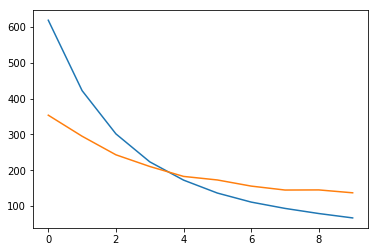

In [21]:
plt.plot(res['train']['normal,1.0'])
plt.plot(res['test']['normal,1.0'])